<a href="https://colab.research.google.com/github/GabrielFePL/Machine-Learning-Fatec-Matao/blob/main/ConsumeDataFromAPI_Exercise_27_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumo de Dataframe de API

## Importação de Bibliotecas

In [20]:
!pip install plotly --upgrade
!pip install squarify --upgrade

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests

## Importação de Database e Criação de Dataframe

In [22]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey=MLXRYWH4X4TY7YWA'

In [23]:
r = requests.get(url)
data = r.json()

In [24]:
time_series = data['Time Series (Daily)']
df = pd.DataFrame.from_dict(time_series, orient='index')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [25]:
df.columns = ['open', 'high', 'low', 'close', 'volumn']
df = df.astype(float)

In [26]:
df

,open,high,low,close,volumn
1999-11-01,98.50,98.810,96.370,96.75,9551800.0
1999-11-02,96.75,96.810,93.690,94.81,11105400.0
1999-11-03,95.87,95.940,93.500,94.37,10369100.0
1999-11-04,94.44,94.440,90.000,91.56,16697600.0
1999-11-05,92.75,92.940,90.190,90.25,13737600.0
...,...,...,...,...,...
2025-03-20,244.24,246.800,237.224,243.32,7026796.0
2025-03-21,241.69,245.205,238.500,243.87,9580084.0
2025-03-24,247.31,248.820,245.965,248.45,4753331.0
2025-03-25,248.36,250.900,248.200,249.90,3133809.0


## Engenharia de Classificadores

### Baseada no classificador 'close'

In [27]:
df['close_tendency'] = df['close'].diff().shift(-1)
df['close_tendency'] = df['close_tendency'].apply(lambda x: 1 if x > 0 else 0)
df

,open,high,low,close,volumn,close_tendency
1999-11-01,98.50,98.810,96.370,96.75,9551800.0,0
1999-11-02,96.75,96.810,93.690,94.81,11105400.0,0
1999-11-03,95.87,95.940,93.500,94.37,10369100.0,0
1999-11-04,94.44,94.440,90.000,91.56,16697600.0,0
1999-11-05,92.75,92.940,90.190,90.25,13737600.0,1
...,...,...,...,...,...,...
2025-03-20,244.24,246.800,237.224,243.32,7026796.0,1
2025-03-21,241.69,245.205,238.500,243.87,9580084.0,1
2025-03-24,247.31,248.820,245.965,248.45,4753331.0,1
2025-03-25,248.36,250.900,248.200,249.90,3133809.0,1


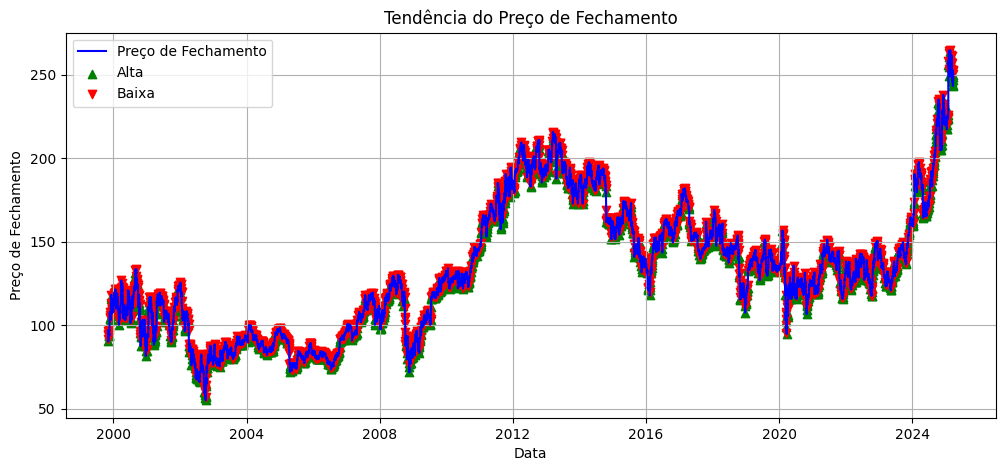

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['close'], label='Preço de Fechamento', color='blue')
plt.scatter(df[df['close_tendency'] == 1].index, df[df['close_tendency'] == 1]['close'], color='green', label='Alta', marker='^')
plt.scatter(df[df['close_tendency'] == 0].index, df[df['close_tendency'] == 0]['close'], color='red', label='Baixa', marker='v')

plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Tendência do Preço de Fechamento')
plt.legend()
plt.grid()
plt.show()

### Baseada no cruzamento dos classificadores 'close' e 'volumn'

In [29]:
df['delta_close'] = df['close'].diff().shift(-1)
df['delta_volumn'] = df['volumn'].diff().shift(-1)

In [30]:
def momentum_classifier(row):
    if row['delta_close'] > 0:
      return 'strong uptrend' if row['delta_volumn'] > 0 else 'distribution phase'
    else:
      return 'lack of conviction' if row['delta_volumn'] < 0 else 'exhaustion signal'

In [31]:
df['momentum'] = df.apply(momentum_classifier, axis=1)
df

,open,high,low,close,volumn,close_tendency,delta_close,delta_volumn,momentum
1999-11-01,98.50,98.810,96.370,96.75,9551800.0,0,-1.94,1553600.0,exhaustion signal
1999-11-02,96.75,96.810,93.690,94.81,11105400.0,0,-0.44,-736300.0,lack of conviction
1999-11-03,95.87,95.940,93.500,94.37,10369100.0,0,-2.81,6328500.0,exhaustion signal
1999-11-04,94.44,94.440,90.000,91.56,16697600.0,0,-1.31,-2960000.0,lack of conviction
1999-11-05,92.75,92.940,90.190,90.25,13737600.0,1,3.69,-5215300.0,distribution phase
...,...,...,...,...,...,...,...,...,...
2025-03-20,244.24,246.800,237.224,243.32,7026796.0,1,0.55,2553288.0,strong uptrend
2025-03-21,241.69,245.205,238.500,243.87,9580084.0,1,4.58,-4826753.0,distribution phase
2025-03-24,247.31,248.820,245.965,248.45,4753331.0,1,1.45,-1619522.0,distribution phase
2025-03-25,248.36,250.900,248.200,249.90,3133809.0,1,0.44,1318411.0,strong uptrend


### Baseada no cruzamento de classificadores 'high', 'low', 'close' e 'volumn'

In [32]:
df['ad'] = ((df['close'] - df['low']) / (df['high'] - df['low'])) * df['volumn']
df['ad_tendency'] = df['ad'].diff().shift(-1)
df.head(10)

,open,high,low,close,volumn,close_tendency,delta_close,delta_volumn,momentum,ad,ad_tendency
1999-11-01,98.50,98.81,96.37,96.75,9551800.0,0,-1.94,1553600.0,exhaustion signal,1.487575e+06,2.498978e+06
1999-11-02,96.75,96.81,93.69,94.81,11105400.0,0,-0.44,-736300.0,lack of conviction,3.986554e+06,-2.893747e+05
1999-11-03,95.87,95.94,93.50,94.37,10369100.0,0,-2.81,6328500.0,exhaustion signal,3.697179e+06,2.169545e+06
1999-11-04,94.44,94.44,90.00,91.56,16697600.0,0,-1.31,-2960000.0,lack of conviction,5.866724e+06,-5.566995e+06
1999-11-05,92.75,92.94,90.19,90.25,13737600.0,1,3.69,-5215300.0,distribution phase,2.997295e+05,8.222571e+06
1999-11-08,90.50,93.94,90.50,93.94,8522300.0,0,-0.32,1028900.0,exhaustion signal,8.522300e+06,-4.283602e+06
1999-11-09,95.06,95.50,92.12,93.62,9551200.0,1,3.38,-870900.0,distribution phase,4.238698e+06,4.264453e+06
1999-11-10,94.62,97.06,94.12,97.00,8680300.0,0,-2.00,-1532800.0,lack of conviction,8.503151e+06,-8.149853e+06
1999-11-11,97.50,97.50,94.87,95.00,7147500.0,1,0.87,2520900.0,strong uptrend,3.532985e+05,8.184642e+06
1999-11-12,96.00,96.25,93.00,95.87,9668400.0,0,-1.81,-3409000.0,lack of conviction,8.537941e+06,-8.062227e+06


In [33]:
def refine_tendency(row):
    if row['ad_tendency'] > 0 and row['close_tendency'] == 1:
        return 1
    elif row['ad_tendency'] < 0 and row['close_tendency'] == 0:
        return 0
    return 0.5 if abs(row['ad_tendency']) < 0.05 * df['ad'].std() else row['close_tendency']

In [34]:
df['tendency'] = df.apply(refine_tendency, axis=1)
df

,open,high,low,close,volumn,close_tendency,delta_close,delta_volumn,momentum,ad,ad_tendency,tendency
1999-11-01,98.50,98.810,96.370,96.75,9551800.0,0,-1.94,1553600.0,exhaustion signal,1.487575e+06,2.498978e+06,0.0
1999-11-02,96.75,96.810,93.690,94.81,11105400.0,0,-0.44,-736300.0,lack of conviction,3.986554e+06,-2.893747e+05,0.0
1999-11-03,95.87,95.940,93.500,94.37,10369100.0,0,-2.81,6328500.0,exhaustion signal,3.697179e+06,2.169545e+06,0.0
1999-11-04,94.44,94.440,90.000,91.56,16697600.0,0,-1.31,-2960000.0,lack of conviction,5.866724e+06,-5.566995e+06,0.0
1999-11-05,92.75,92.940,90.190,90.25,13737600.0,1,3.69,-5215300.0,distribution phase,2.997295e+05,8.222571e+06,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-20,244.24,246.800,237.224,243.32,7026796.0,1,0.55,2553288.0,strong uptrend,4.473198e+06,3.199442e+06,1.0
2025-03-21,241.69,245.205,238.500,243.87,9580084.0,1,4.58,-4826753.0,distribution phase,7.672640e+06,-3.535327e+06,1.0
2025-03-24,247.31,248.820,245.965,248.45,4753331.0,1,1.45,-1619522.0,distribution phase,4.137313e+06,-2.164174e+06,1.0
2025-03-25,248.36,250.900,248.200,249.90,3133809.0,1,0.44,1318411.0,strong uptrend,1.973139e+06,-1.220258e+06,1.0


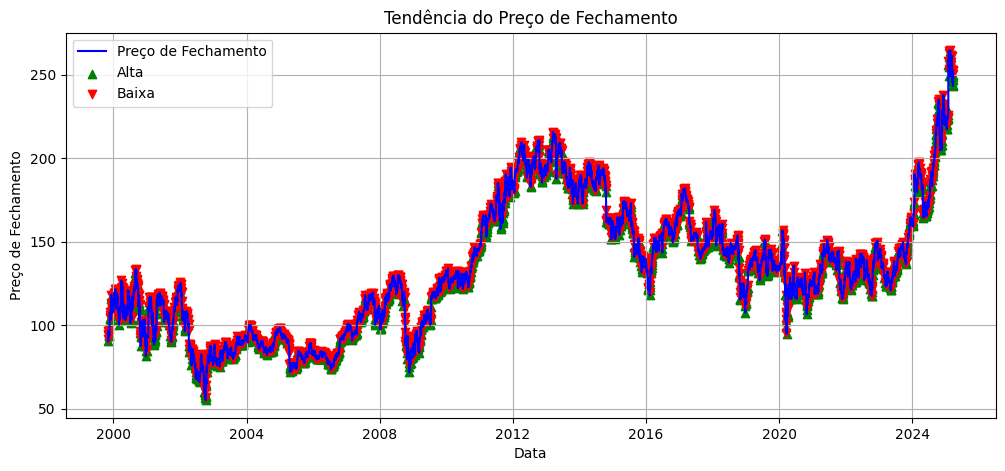

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['close'], label='Preço de Fechamento', color='blue')
plt.scatter(df[df['tendency'] == 1].index, df[df['tendency'] == 1]['close'], color='green', label='Alta', marker='^')
plt.scatter(df[df['tendency'] == 0].index, df[df['tendency'] == 0]['close'], color='red', label='Baixa', marker='v')

plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Tendência do Preço de Fechamento')
plt.legend()
plt.grid()
plt.show()